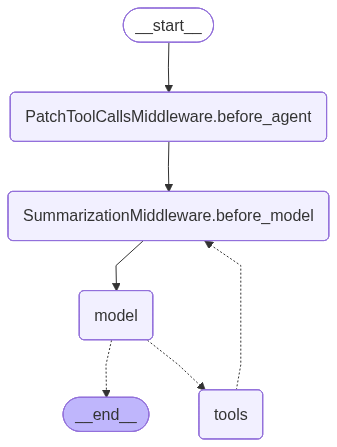

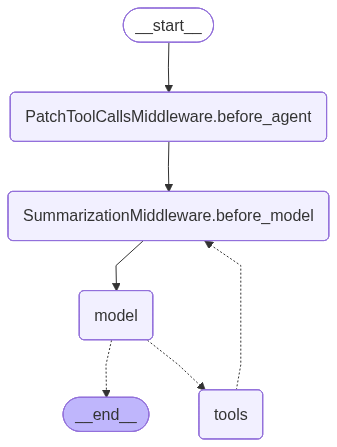

'\nThat diagram is the main agent’s internal LangChain agent pipeline that create_deep_agent(...) builds for you.\n\nWhy you see two middlewares before the model\n\nPatchToolCallsMiddleware.before_agent\nDeep Agents inserts this wrapper so tool calls coming out of the model are in the exact shape the Deep Agents runtime expects (tool name mapping, args normalization, routing to “tools” vs “subagents”, and consistent message formatting for the LangGraph loop).\nSo even if you never pass any middleware, this one is typically injected by the framework because the whole deep-agent orchestration depends on it.\n\nSummarizationMiddleware.before_model\nDeep Agents also enables automatic context compaction on the main agent by default (the “automatic context compaction” you mention). In practice, this is implemented as a summarization middleware that runs right before calling the model, so the conversation is compacted once it crosses a threshold.\n'

In [ ]:
# agent_notebook.ipynb cell
from IPython.display import Image, display

# change this to your actual module filename (the .py that defines `agent = create_research_agent()`)
from agent import agent

display(Image(agent.get_graph().draw_mermaid_png()))

"""
That diagram is the main agent’s internal LangChain agent pipeline that create_deep_agent(...) builds for you.

Why you see two middlewares before the model

PatchToolCallsMiddleware.before_agent
Deep Agents inserts this wrapper so tool calls coming out of the model are in the exact shape the Deep Agents runtime expects (tool name mapping, args normalization, routing to “tools” vs “subagents”, and consistent message formatting for the LangGraph loop).
So even if you never pass any middleware, this one is typically injected by the framework because the whole deep-agent orchestration depends on it.
This is inserted incase we made a deep agent taking input of a tool call downstream we do not need here

SummarizationMiddleware.before_model
Deep Agents also enables automatic context compaction on the main agent by default (the “automatic context compaction” you mention). In practice, this is implemented as a summarization middleware that runs right before calling the model, so the conversation is compacted once it crosses a threshold.
"""

# Deep Research Agent - Memory Management

This notebook allows you to:
1. View what's in the agent's long-term memory
2. Add memories manually (e.g., pre-seed website quality ratings)
3. Update or delete memories
4. Search memories semantically

## Setup

In [ ]:
import os
import uuid
import json
from datetime import datetime
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Check if we have database connection
DATABASE_URL = os.environ.get("DATABASE_URL")
if DATABASE_URL:
    print(f"✅ Database configured")
else:
    print("⚠️  No DATABASE_URL found - using in-memory store (memories won't persist)")

In [ ]:
# Initialize the store
if DATABASE_URL:
    from langgraph.store.postgres import PostgresStore
    store = PostgresStore.from_conn_string(DATABASE_URL)
    print("Using PostgreSQL store")
else:
    from langgraph.store.memory import InMemoryStore
    store = InMemoryStore()
    print("Using in-memory store")

## Memory Namespace Structure

The agent uses a simple namespace structure:
- `("agent", "memories")` - The default namespace for agent memories

Within this namespace, files are stored as:
- `website_quality.txt` - Website reliability ratings
- `research_lessons.txt` - What approaches worked well
- `source_notes.txt` - Notes about specific sources

In [ ]:
# Define the namespace for agent memories
MEMORY_NAMESPACE = ("agent", "memories")

## 1. View All Memories

In [ ]:
def list_all_memories():
    """List all memories in the agent's namespace."""
    memories = store.search(MEMORY_NAMESPACE)
    
    if not memories:
        print("📭 No memories found")
        return []
    
    print(f"📚 Found {len(memories)} memories:\n")
    for i, mem in enumerate(memories, 1):
        print(f"--- Memory {i} ---")
        print(f"Key: {mem.key}")
        print(f"Created: {mem.created_at}")
        print(f"Updated: {mem.updated_at}")
        print(f"Content: {json.dumps(mem.value, indent=2)[:500]}..." if len(str(mem.value)) > 500 else f"Content: {json.dumps(mem.value, indent=2)}")
        print()
    
    return memories

# List all memories
all_memories = list_all_memories()

## 2. View Specific Memory File

In [ ]:
def get_memory(key: str):
    """Get a specific memory by key."""
    try:
        memory = store.get(MEMORY_NAMESPACE, key)
        if memory:
            print(f"📄 Memory: {key}")
            print(f"Created: {memory.created_at}")
            print(f"Updated: {memory.updated_at}")
            print(f"\nContent:\n{json.dumps(memory.value, indent=2)}")
            return memory
        else:
            print(f"❌ Memory '{key}' not found")
            return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Example: Get website quality memory
# get_memory("website_quality.txt")

## 3. Add/Update Memories Manually

In [ ]:
def save_memory(key: str, content: str):
    """Save or update a memory."""
    store.put(
        MEMORY_NAMESPACE,
        key,
        {"content": content, "updated_by": "manual", "timestamp": datetime.now().isoformat()}
    )
    print(f"✅ Saved memory: {key}")


def append_to_memory(key: str, new_content: str):
    """Append content to an existing memory."""
    existing = store.get(MEMORY_NAMESPACE, key)
    if existing:
        current_content = existing.value.get("content", "")
        updated_content = current_content + "\n" + new_content
    else:
        updated_content = new_content
    
    save_memory(key, updated_content)
    print(f"✅ Appended to memory: {key}")

### Pre-seed Website Quality Ratings

Add initial ratings for commonly used sources:

In [ ]:
# Pre-seed website quality ratings
WEBSITE_QUALITY_SEED = """
# Website Quality Ratings
Last updated: {date}

## HIGH QUALITY (5/5) - Prefer these sources
- arxiv.org - Academic preprints, peer-reviewed quality
- nature.com - Premier scientific journal
- science.org - Top scientific journal  
- gov domains (.gov) - Official government data
- edu domains (.edu) - Academic institutions
- reuters.com - Reliable news, minimal bias
- apnews.com - Associated Press, factual reporting

## GOOD QUALITY (4/5) - Generally reliable
- nytimes.com - Quality journalism, some editorial bias
- wsj.com - Business focus, generally reliable
- bbc.com - International perspective, reliable
- theguardian.com - Quality journalism, progressive lean
- techcrunch.com - Tech news, industry insider view
- wired.com - Tech and science, well-researched

## MODERATE QUALITY (3/5) - Use with verification
- wikipedia.org - Good starting point, verify claims
- medium.com - Varies by author, check credentials
- forbes.com - Mix of journalism and contributor posts
- businessinsider.com - News with clickbait tendencies

## LOW QUALITY (2/5) - Approach with caution
- Social media (Twitter/X, Reddit) - Unverified, use for sentiment only
- Content farms - Thin content, often inaccurate
- Sites with excessive ads - Often prioritize clicks over accuracy

## UNRELIABLE (1/5) - Avoid or heavily verify
- Known misinformation sites
- Anonymous blogs without citations
- Sites that only confirm one viewpoint
""".format(date=datetime.now().strftime("%Y-%m-%d"))

# Uncomment to save this as initial website quality memory:
# save_memory("website_quality.txt", WEBSITE_QUALITY_SEED)

### Pre-seed Research Lessons

In [ ]:
RESEARCH_LESSONS_SEED = """
# Research Lessons Learned
Last updated: {date}

## Search Strategies That Work
- Start broad, then narrow with specific terms
- Include year in searches for recent topics (e.g., "AI agents 2024")
- Search for "[topic] research paper" to find academic sources
- Search for "[topic] criticism" to find counter-arguments
- Use site-specific searches: "site:arxiv.org [topic]"

## Common Pitfalls to Avoid
- Don't rely on a single source for important claims
- Check dates - old information may be outdated
- Be wary of sources that confirm bias without evidence
- Marketing content often exaggerates - verify claims
- Statistics without context can be misleading

## Verification Best Practices
- Cross-reference numbers with primary sources
- Check author credentials and affiliations
- Look for methodology descriptions in studies
- Note sample sizes and confidence intervals
- Consider who funded the research
""".format(date=datetime.now().strftime("%Y-%m-%d"))

# Uncomment to save:
# save_memory("research_lessons.txt", RESEARCH_LESSONS_SEED)

## 4. Delete Memories

In [ ]:
def delete_memory(key: str):
    """Delete a specific memory."""
    try:
        store.delete(MEMORY_NAMESPACE, key)
        print(f"🗑️ Deleted memory: {key}")
    except Exception as e:
        print(f"❌ Error deleting: {e}")


def clear_all_memories():
    """Delete ALL memories (use with caution!)."""
    memories = store.search(MEMORY_NAMESPACE)
    for mem in memories:
        store.delete(MEMORY_NAMESPACE, mem.key)
    print(f"🗑️ Cleared {len(memories)} memories")

# Example:
# delete_memory("old_file.txt")
# clear_all_memories()  # ⚠️ Careful!

## 5. Search Memories Semantically

If you have embeddings configured, you can search memories by meaning:

In [ ]:
def search_memories(query: str, limit: int = 5):
    """Search memories semantically."""
    results = store.search(MEMORY_NAMESPACE, query=query, limit=limit)
    
    if not results:
        print(f"No memories found matching: '{query}'")
        return []
    
    print(f"🔍 Search results for '{query}':\n")
    for i, mem in enumerate(results, 1):
        print(f"{i}. {mem.key}")
        content = str(mem.value.get('content', mem.value))[:200]
        print(f"   Preview: {content}...\n")
    
    return results

# Example:
# search_memories("which websites are reliable for research")

## 6. Export/Import Memories (Backup)

In [ ]:
def export_memories(filepath: str = "memories_backup.json"):
    """Export all memories to a JSON file."""
    memories = store.search(MEMORY_NAMESPACE)
    
    export_data = [
        {
            "key": mem.key,
            "value": mem.value,
            "created_at": str(mem.created_at),
            "updated_at": str(mem.updated_at)
        }
        for mem in memories
    ]
    
    with open(filepath, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"📤 Exported {len(memories)} memories to {filepath}")


def import_memories(filepath: str = "memories_backup.json"):
    """Import memories from a JSON file."""
    with open(filepath, 'r') as f:
        import_data = json.load(f)
    
    for mem in import_data:
        store.put(MEMORY_NAMESPACE, mem["key"], mem["value"])
    
    print(f"📥 Imported {len(import_data)} memories from {filepath}")

# Example:
# export_memories("my_backup.json")
# import_memories("my_backup.json")

## 7. Initialize All Seed Memories

Run this cell to pre-populate the agent with useful initial memories:

In [ ]:
def initialize_memories():
    """Initialize the agent with seed memories."""
    print("🌱 Initializing seed memories...\n")
    
    save_memory("website_quality.txt", WEBSITE_QUALITY_SEED)
    save_memory("research_lessons.txt", RESEARCH_LESSONS_SEED)
    save_memory("source_notes.txt", "# Source Notes\n\nAdd notes about specific sources here.\n")
    
    print("\n✅ Memories initialized!")
    list_all_memories()

# Uncomment to initialize:
# initialize_memories()